In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score  
from sklearn.metrics import f1_score  
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix  
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Constant
from tensorflow.keras import optimizers
from keras import utils
from keras.models import Sequential
from keras.layers import (LSTM, 
                          Activation,
                          Conv1D,
                          MaxPooling1D,
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('omw-1.4')

import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict

import warnings 
warnings.filterwarnings('ignore')

# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import string
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import random
import datetime


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [3]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
train.info()
train.head()
# sub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_NoTarget = train.drop('target', axis=1)
all_data = pd.concat([train_NoTarget,test],axis=0,ignore_index=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10876 non-null  int64 
 1   keyword   10789 non-null  object
 2   location  7238 non-null   object
 3   text      10876 non-null  object
dtypes: int64(1), object(3)
memory usage: 340.0+ KB


Text(0.5, 1.0, 'Sentiment Distribution')

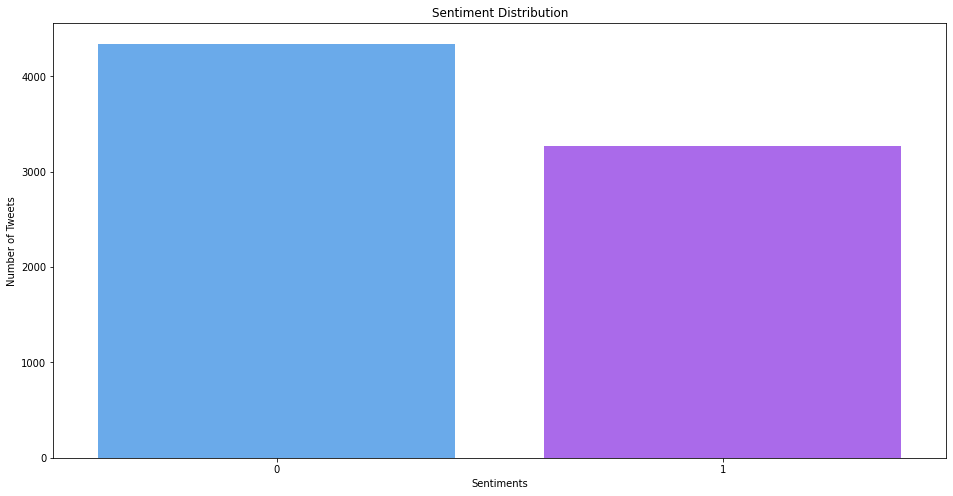

In [5]:
plt.figure(figsize=(16,8))
x = train.target.value_counts()
sns.barplot(x.index, x, palette='cool')
plt.gca().set_ylabel('Number of Tweets')
plt.gca().set_xlabel('Sentiments')
plt.title("Sentiment Distribution")

In [6]:

stop_words = set(stopwords.words("english"))
stop_words.remove('not')
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stop_words = stop_words.union(more_stopwords)
                 
stemmer = SnowballStemmer("english")

In [7]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)


# modify data to remove punctuations, emojis, etc.
all_data['mod_text'] = all_data['text'].apply(lambda x: remove_URL(x))
all_data['mod_text'] = all_data['mod_text'].apply(lambda x: remove_emoji(x))
all_data['mod_text'] = all_data['mod_text'].apply(lambda x: remove_html(x))
all_data['mod_text'] = all_data['mod_text'].apply(lambda x: remove_punct(x))
all_data['mod_text'] = all_data['mod_text'].apply(lambda x: remove_quotes(x))

#tokenize text
all_data['tokenized'] = all_data['mod_text'].apply(word_tokenize)

#lowercase all text
all_data['lower'] = all_data['tokenized'].apply(
    lambda x: [word.lower() for word in x])

#remove stop words
all_data['stopwords_removed'] = all_data['lower'].apply(
    lambda x: [word for word in x if word not in stop_words])

all_data.head()

,id,keyword,location,text,mod_text,tokenized,lower,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [8]:
#apply speech tags 
all_data['pos_tags'] = all_data['stopwords_removed'].apply(nltk.tag.pos_tag)
all_data.head()

,id,keyword,location,text,mod_text,tokenized,lower,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


In [9]:
#apply wordnet tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


all_data['wordnet_pos'] = all_data['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

all_data.head()


,id,keyword,location,text,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."


In [10]:
#lemmatize the data 
wnl = WordNetLemmatizer()

all_data['lemmatized'] = all_data['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

all_data['lemmatized'] = all_data['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop_words])

all_data['lemma_str'] = [' '.join(map(str, l)) for l in all_data['lemmatized']]

all_data.head()

,id,keyword,location,text,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


In [11]:
all_data_post = all_data[['lemma_str', 'id']]
all_data_post.head()

,lemma_str,id
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,4
2,resident ask shelter place notify officer evac...,5
3,13000 people receive wildfire evacuation order...,6
4,get sent photo ruby alaska smoke wildfires pou...,7


In [12]:
#post-processed train, test sets 
train_post = pd.merge(train, all_data_post, on='id')
y = train_post['target']
test_post = pd.merge(test,all_data_post, on='id')

In [13]:
#sentiment analysis using RNN and LSTM blocks 
#create vocab and tokens 
tokenizer=Tokenizer(num_words=3000,split=' ')
tokenizer.fit_on_texts(train_post['lemma_str'].values)
X = tokenizer.texts_to_sequences(train_post['lemma_str'].values)
X = pad_sequences(X)

#split train set into train and dev sets 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =41)


In [14]:
#create model 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(3000, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

2022-09-27 09:58:16.041298: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55a0ee89d7e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-27 09:58:16.041384: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2022-09-27 09:58:16.043018: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            96000     
_________________________________________________________________
dropout (Dropout)            (None, 20, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
#fit model 
history = model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test), callbacks= [callbacks])

Epoch 1/10


2022-09-27 09:58:16.418570: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


191/191 [==============================] - 11s 36ms/step - loss: 0.5422 - accuracy: 0.7241 - val_loss: 0.4423 - val_accuracy: 0.7997
Epoch 2/10
191/191 [==============================] - 7s 35ms/step - loss: 0.3741 - accuracy: 0.8391 - val_loss: 0.4581 - val_accuracy: 0.8004
Epoch 3/10
191/191 [==============================] - 6s 33ms/step - loss: 0.3220 - accuracy: 0.8660 - val_loss: 0.5004 - val_accuracy: 0.8011
Epoch 4/10
191/191 [==============================] - 6s 33ms/step - loss: 0.2885 - accuracy: 0.8795 - val_loss: 0.5269 - val_accuracy: 0.7932
Epoch 5/10
191/191 [==============================] - 6s 34ms/step - loss: 0.2517 - accuracy: 0.8997 - val_loss: 0.6413 - val_accuracy: 0.7866
Epoch 6/10
191/191 [==============================] - 6s 34ms/step - loss: 0.2268 - accuracy: 0.9072 - val_loss: 0.6321 - val_accuracy: 0.7814
Epoch 7/10
191/191 [==============================] - 7s 35ms/step - loss: 0.1763 - accuracy: 0.9309 - val_loss: 0.7387 - val_accuracy: 0.7781
Epoch 8/1

In [16]:
#predict over dev set and obtain accuracy, precision, recall
y_pred = model.predict(X_test).round()
train_accuracy = round(metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
print("Training Accuracy Obtained =", train_accuracy, '%')
print('Dev Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Dev Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Dev Precision  is : ', (metrics.precision_score(y_test, y_pred)))

Training Accuracy Obtained = 95 %
Dev Accuracy  is  :  0.7747866053841103
Dev Recall  is    :  0.7576219512195121
Dev Precision  is :  0.7298091042584435


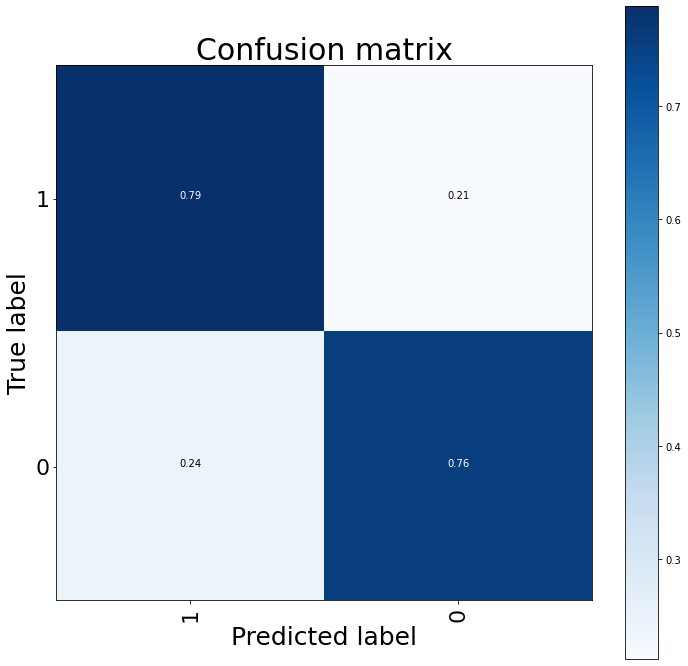

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       867
           1       0.73      0.76      0.74       656

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.77      0.78      1523



In [17]:
# confusion matrix 

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=y_train.unique(), title="Confusion matrix")
plt.show()
print(classification_report(y_test, y_pred))

In [18]:
#prediction on test data set 
l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_post['lemma_str'].values)
X = tokenizer.texts_to_sequences(train_post['lemma_str'].values)
X = pad_sequences(X, maxlen =l)
tokenizer.fit_on_texts(train_post['lemma_str'].values)
test_token = tokenizer.texts_to_sequences(test_post['lemma_str'].values)
test_token = pad_sequences(test_token, maxlen =l)

In [19]:
#tuned model 

embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [20]:
#fit tuned model on training data 
model.fit(X,y, epochs = 10,validation_split = 0.2 ,callbacks=[callbacks], batch_size=32)
y_hat = model.predict(test_token).round()

Epoch 1/10
191/191 [==============================] - 80s 381ms/step - loss: 0.5184 - accuracy: 0.7456 - val_loss: 0.4620 - val_accuracy: 0.7833
Epoch 2/10
191/191 [==============================] - 71s 374ms/step - loss: 0.3527 - accuracy: 0.8548 - val_loss: 0.4938 - val_accuracy: 0.7754
Epoch 3/10
191/191 [==============================] - 71s 372ms/step - loss: 0.2927 - accuracy: 0.8860 - val_loss: 0.5830 - val_accuracy: 0.7636
Epoch 4/10
191/191 [==============================] - 72s 379ms/step - loss: 0.2347 - accuracy: 0.9110 - val_loss: 0.6867 - val_accuracy: 0.7538
Epoch 5/10
191/191 [==============================] - 71s 371ms/step - loss: 0.1893 - accuracy: 0.9248 - val_loss: 0.7605 - val_accuracy: 0.7406
Epoch 6/10
191/191 [==============================] - 72s 376ms/step - loss: 0.1371 - accuracy: 0.9473 - val_loss: 0.9813 - val_accuracy: 0.7288
Epoch 7/10
191/191 [==============================] - 73s 384ms/step - loss: 0.0993 - accuracy: 0.9591 - val_loss: 1.1117 - val_ac